<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting/blob/main/Sector_Indices_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2024-04-09 21:17:59


In [2]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

In [3]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta

from google.colab import data_table

In [4]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-10*365)).strftime('%Y-%m-%d')
start1_date = (datetime.date.today() + datetime.timedelta(days=-1*365)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')

In [5]:
# fetch nse indices scrips

import pandas as pd
import numpy as np

df_nse_sectors = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/NSE_Sectors_Indices.csv')

In [6]:
sectors = df_nse_sectors['Sector'].unique()
df_sectors = pd.DataFrame()
for sector in sectors:
  stocks = df_nse_sectors[df_nse_sectors['Sector'] == sector]['Symbol'].values
  df_sector = pd.DataFrame()
  tweight = 0
  for stock in stocks:
    stock_df = yfin.Ticker(stock+'.NS').history(period='10y', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    col = ['Close']
    stock_df = stock_df[col]
    stock_df['Split'] = 1
    weight = df_nse_sectors[df_nse_sectors['Symbol'] == stock]['Weight'].values[0]
    tweight = sum(df_nse_sectors[df_nse_sectors['Sector'] == sector]['Weight'].values)
    if stock == 'NESTLEIND':
      stock_df.loc[stock_df.index < '2024-01-01', 'Split'] = 10
    #stock_df[stock] = (stock_df[col]*weight)/(tweight*stock_df['Split'].values[0])
    stock_df[stock] = stock_df['Close']/stock_df['Split']
    col = [stock]
    stock_df = stock_df[col]
    df_sector = pd.concat([df_sector, stock_df], axis=1)

  df_sector[sector] = df_sector[stocks].sum(axis=1)
  col = [sector]
  df_sector = df_sector[col]
  df_sectors = pd.concat([df_sectors, df_sector], axis=1)
df_sectors

,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES
Date,,,,,,,,,,,,,,
2014-04-09 00:00:00+05:30,6010.559952,1409.204041,333.264080,1998.913300,1250.055280,5480.057083,624.558643,665.770147,4944.707500,1249.710802,8933.303909,648.285934,498.583572,376.840003
2014-04-10 00:00:00+05:30,6008.506912,1423.061737,336.859734,1979.878494,1263.074554,5361.769608,624.253883,675.325373,4995.522078,1279.141672,8983.949219,647.218872,495.316422,381.529313
2014-04-11 00:00:00+05:30,5933.696320,1417.174606,332.270737,2015.759064,1260.536505,5397.745102,616.915228,665.937721,4997.253780,1282.760727,9230.760101,641.948257,495.097198,396.030263
2014-04-15 00:00:00+05:30,5934.308830,1388.019241,330.876518,2070.956985,1259.513013,5368.712921,614.001137,638.119205,4937.905657,1269.004499,9139.096741,638.951538,486.625984,393.197978
2014-04-16 00:00:00+05:30,5892.403763,1383.207443,331.269455,2027.089264,1254.119193,5332.508621,608.822914,642.922781,4897.682985,1264.991947,9120.875702,631.880981,487.988640,394.846104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-03 00:00:00+05:30,31168.349976,6124.950012,10343.299973,13571.449890,12673.100037,18232.349731,2991.409943,6043.899933,27218.150009,21004.500168,41667.551086,19929.850281,4824.150024,5825.100014
2024-04-04 00:00:00+05:30,31337.350464,6177.849915,10333.149933,13731.500214,12683.400146,18204.000000,2972.871986,6027.750031,27228.149841,20855.649979,41182.749573,19793.749969,4918.850006,5821.799862
2024-04-05 00:00:00+05:30,31045.799438,6241.950073,10263.049866,13679.549988,12654.499695,18285.899780,2957.449955,6050.000031,26934.699707,20628.300079,40826.050476,19839.650085,4883.899963,5815.800011


In [7]:
def stock_prec_dev(stock_symbol):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = df_sectors[[stock_symbol]]
    stock_df.columns = ['Close']

    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Sector'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)
    stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start1_date)]
    stock_df['Min'] = round(min(stock_df['Close']),2)
    #stock_df['Gained%'] = round((stock_df['Close'] - stock_df['Min'])*100/stock_df['Min'],2)
    stock_df.ta.rsi(append=True)
    #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
    #stock_df['Close'] = round(stock_df['Close'],0)
    stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
    stock_df['ATH%'] = round((stock_df['Max'] - stock_df['Close'])*100/stock_df['Close'],2)
    #stock_df['Sector'] = stock_symbol
    stock_df = stock_df.tail(1)
    return stock_df

In [8]:
df_final =  pd.DataFrame()
for sector in sectors:

  df_tmp = stock_prec_dev(sector)
  df_final = pd.concat([df_final, df_tmp], ignore_index = True) #df_final.append(df_tmp)
# all sectors
df_final = df_final.sort_values(by = 'ATH%', ascending=False)
#data_table.DataTable(df_final, include_index=False)
df_final

,Close,200_SMA,Dev%_200,Sector,Max,Min,RSI_14,ATH%
6,2915.75,3203.0,-8.97,MEDIA,3802.31,1269.75,48.0,30.41
3,13601.75,13440.0,1.20,IT,16479.95,10689.25,37.0,21.16
10,40899.15,39556.0,3.40,CEMENT,44858.64,14617.05,52.0,9.68
4,12548.40,10809.0,16.09,FMCG,13510.72,7994.31,49.0,7.67
12,4793.50,4491.0,6.74,JEWELLERY,5100.03,3525.55,49.0,6.39
13,5816.05,5592.0,4.01,TEXTILES,6093.95,4636.99,56.0,4.78
2,10262.55,9763.0,5.12,FINANCE,10620.93,7378.50,69.0,3.49
7,6068.20,5081.0,19.43,METAL,6262.29,3782.80,64.0,3.20
1,6280.40,5995.0,4.76,BANKS,6391.75,5585.95,68.0,1.77
5,18341.40,16221.0,13.07,PHARMA,18529.05,12257.17,57.0,1.02


<Axes: xlabel='Date'>

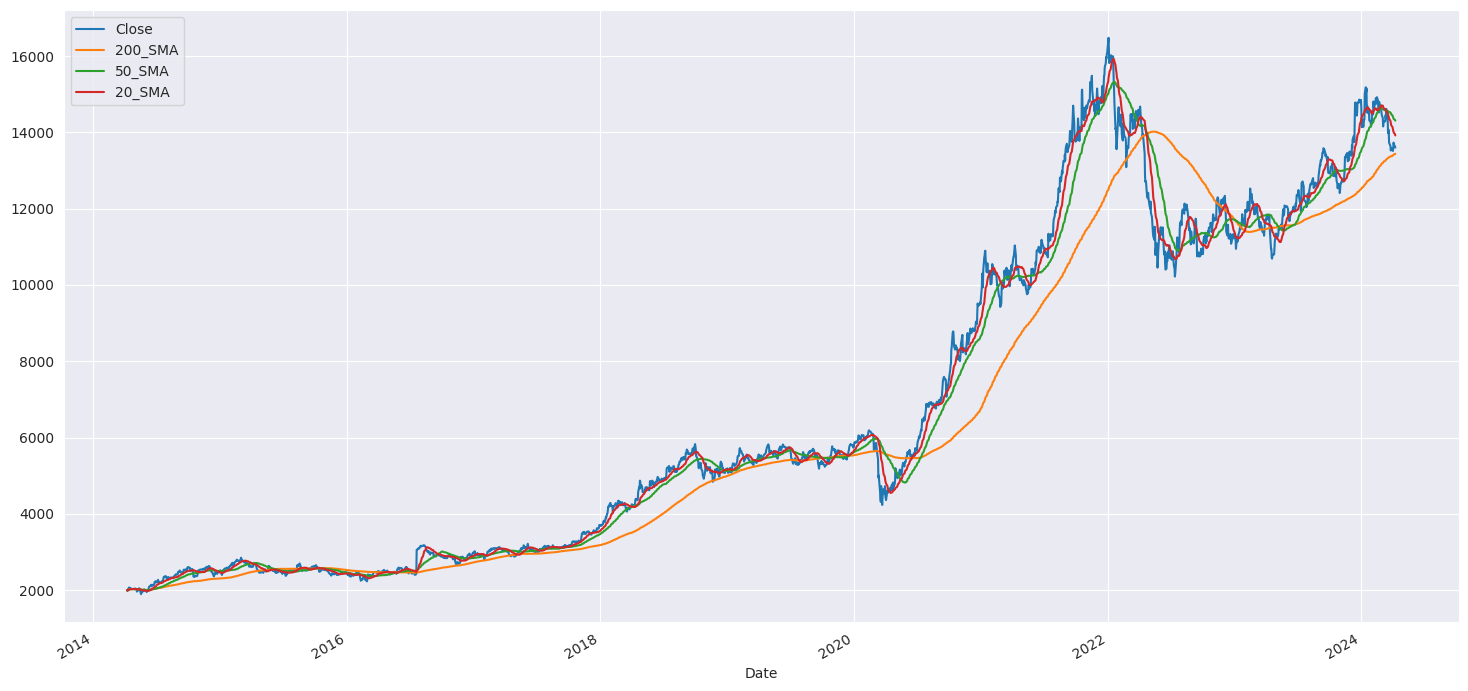

In [9]:
col = ['IT']
sector_df = df_sectors[col]
sector_df.columns = ['Close']
sector_df['200_SMA'] = round(sector_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
sector_df['50_SMA'] = round(sector_df['Close'].rolling(window = 50, min_periods = 1).mean(),0)
sector_df['20_SMA'] = round(sector_df['Close'].rolling(window = 20, min_periods = 1).mean(),0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = sector_df.reset_index()
tmp_df.plot(x='Date', y=['Close','200_SMA','50_SMA','20_SMA'], figsize=(18,9))

In [13]:
df_sectors = df_sectors[(df_sectors.index <= end_date) & (df_sectors.index >= start1_date)]
for sector in sectors:
  base_value = df_sectors[sector].head(1).values[0]
  df_sectors[sector] = df_sectors[sector]*100/base_value

df_sectors

,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES
Date,,,,,,,,,,,,,,
2023-04-10 00:00:00+05:30,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2023-04-11 00:00:00+05:30,101.572888,102.079421,100.399933,98.973507,100.504285,100.058904,100.940200,101.464273,100.507029,100.228550,100.687528,99.962202,99.741160,99.849626
2023-04-12 00:00:00+05:30,102.106915,102.453274,100.586046,100.020420,100.238963,104.015766,100.178843,102.728662,100.403637,100.017662,100.378103,99.493413,99.264026,100.570323
2023-04-13 00:00:00+05:30,102.392698,103.513766,101.427520,97.342831,101.006253,103.323801,99.228613,103.557132,100.556820,100.698745,99.519625,100.429218,98.885638,100.481183
2023-04-17 00:00:00+05:30,102.432807,103.752877,102.254245,92.473570,102.237652,102.931667,98.449473,104.028421,100.771960,101.366368,99.152492,100.673090,99.034802,101.928808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-03 00:00:00+05:30,177.534022,108.953608,140.181578,114.655097,146.037520,148.730455,106.800281,159.772984,147.174478,132.207334,110.674297,197.078219,133.686374,125.433512
2024-04-04 00:00:00+05:30,178.496644,109.894617,140.044016,116.007244,146.156212,148.499192,106.138433,159.346055,147.228549,131.270436,109.386603,195.732378,136.310691,125.362449
2024-04-05 00:00:00+05:30,176.835978,111.034862,139.093957,115.568355,145.823180,149.167290,105.587831,159.934243,145.641800,129.839441,108.439165,196.186266,135.342159,125.233252


<Axes: xlabel='Date'>

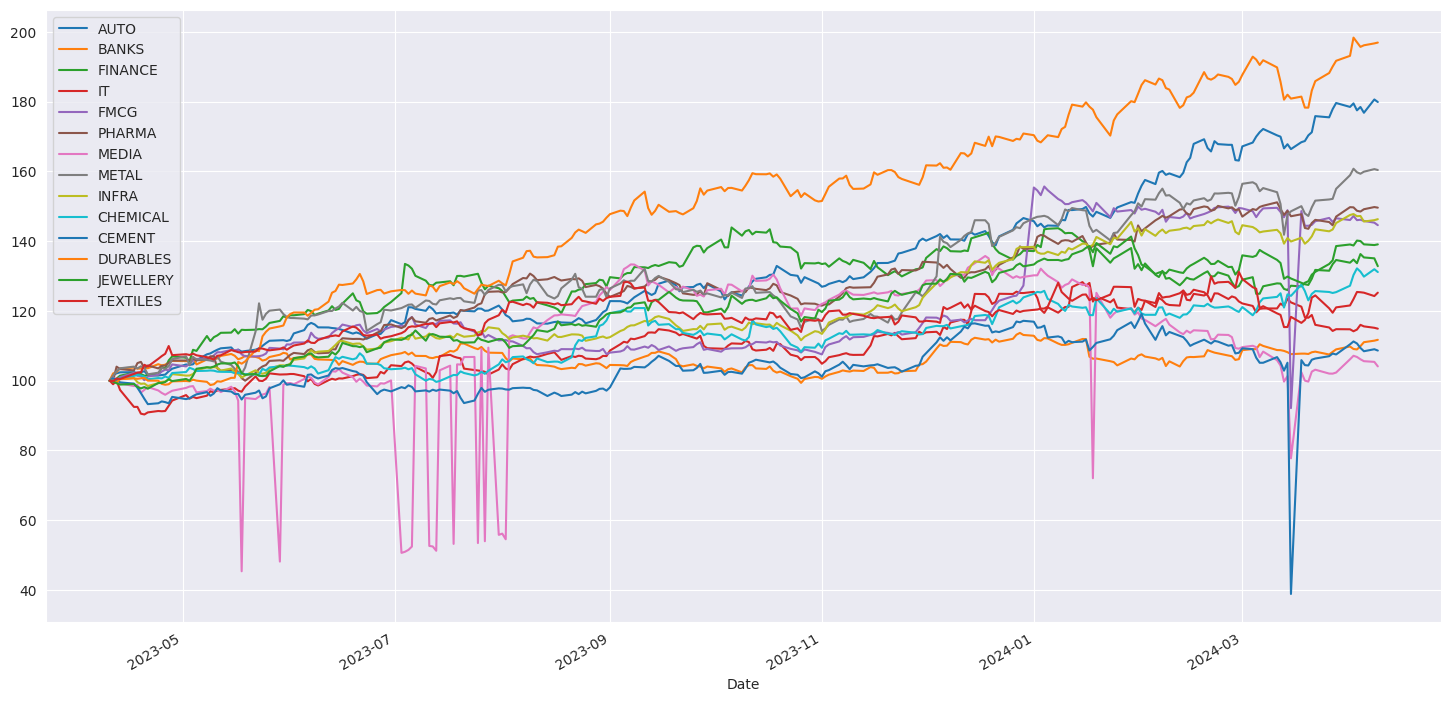

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = df_sectors.reset_index()
tmp_df.plot(x='Date', y=['AUTO', 'BANKS', 'FINANCE', 'IT', 'FMCG', 'PHARMA', 'MEDIA', 'METAL', 'INFRA', 'CHEMICAL', 'CEMENT', 'DURABLES', 'JEWELLERY', 'TEXTILES'], figsize=(18,9))

In [12]:
tmp_df

,Date,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES
0,2023-04-10 00:00:00+05:30,292.090402,398.921142,2214.010464,592.159803,694.207331,223.695709,448.466816,568.184786,374.011963,1271.297751,421.443244,1559.907364,723.761863,1232.346412
1,2023-04-11 00:00:00+05:30,296.684656,407.216390,2222.865024,586.081321,697.708116,223.827474,452.683302,576.504562,375.908314,1274.203295,424.340786,1559.317755,721.888481,1230.493286
2,2023-04-12 00:00:00+05:30,298.244499,408.707771,2226.985593,592.280719,695.866232,232.678805,449.268870,583.688630,375.521616,1271.522292,423.036734,1552.005080,718.435163,1239.374766
3,2023-04-13 00:00:00+05:30,299.079242,412.938299,2245.615900,576.425113,701.192812,231.130909,445.007402,588.395867,376.094538,1280.180882,419.418734,1566.602774,715.696535,1238.276255
4,2023-04-17 00:00:00+05:30,299.196397,413.892163,2263.919692,547.591308,709.741273,230.253722,441.513216,591.073660,376.899186,1288.668361,417.871479,1570.406943,716.776127,1256.116004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2024-04-03 00:00:00+05:30,518.559838,434.638976,3103.634802,678.941397,1013.803169,332.703646,478.963821,907.805788,550.450153,1680.748869,466.429347,3074.237651,967.570993,1545.775385
243,2024-04-04 00:00:00+05:30,521.371565,438.392861,3100.589158,686.948264,1014.627141,332.186321,475.995652,905.380041,550.652386,1668.838098,461.002446,3053.243780,986.564796,1544.899642
244,2024-04-05 00:00:00+05:30,516.520918,442.941540,3079.554768,684.349341,1012.315207,333.680827,473.526383,908.722035,544.717755,1650.645897,457.009533,3060.324007,979.554930,1543.307494
245,2024-04-08 00:00:00+05:30,527.653830,444.683657,3075.128839,681.958041,1008.783369,335.074060,472.637753,912.905159,546.178920,1677.612104,459.436392,3068.807880,977.689636,1531.352810
